# Segmentation

This notebook regarde semantic segmentation using the [PascalVOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) dataset and PyTorch library. The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented.

Let's first install and load the library we will use throught the notebook.

In [1]:
!pip install torchmetrics
!pip install monai
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.transforms.functional import InterpolationMode
import torchmetrics
from torch.utils.data import DataLoader
from PIL import Image
import torchvision
from torchvision.models.segmentation import FCN_ResNet50_Weights
import torch.nn.functional as F
import monai
import torchvision.transforms.functional as TF

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 34.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.5 MB/s eta 0:00:00


# Data

In this notebook we will use the [PascalVOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) for semantic segmentation. 20 classes are defined (+ background) and an additional label (255) is used for the void category, i.e. border regions (5px) and mask for difficult objects. In the following we will consider these pixels as background and therefore we will have 21 classes in total.

We define here some auxiliary functions to:
<ul>
    <li> Change the pixel values of void category to background</li>
    <li> Plot a group of images </li>
</ul>

In [2]:
def replace_tensor_value_(tensor, a, b):
    tensor[tensor == a] = b
    return tensor


def plot_images(images, num_per_row=8, title=None, vmax=None):
    num_rows = int(math.ceil(len(images) / num_per_row))

    fig, axes = plt.subplots(num_rows, num_per_row, dpi=150)
    fig.subplots_adjust(wspace=0, hspace=0)
    for image, ax in zip(images, axes.flat):
        ax.imshow(image, vmax=vmax)
        ax.axis('off')

    return fig

Now we define the classes for PascalVOC segmantic segementation (from 0 to 20) and the color palette used for their representation in RGB. (These variables are not used in the following but can be useful if you want to further experiment with this dataset)

In [3]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]
# Color palette for segmentation masks in RGB
PALETTE = np.array(
    [
        [0, 0, 0],
        [128, 0, 0],
        [0, 128, 0],
        [128, 128, 0],
        [0, 0, 128],
        [128, 0, 128],
        [0, 128, 128],
        [128, 128, 128],
        [64, 0, 0],
        [192, 0, 0],
        [64, 128, 0],
        [192, 128, 0],
        [64, 0, 128],
        [192, 0, 128],
        [64, 128, 128],
        [192, 128, 128],
        [0, 64, 0],
        [128, 64, 0],
        [0, 192, 0],
        [128, 192, 0],
        [0, 64, 128],
    ]
    + [[0, 0, 0] for i in range(256 - 22)] # Maybe not used 
    + [[255, 255, 255]], # Maybe not used either
    dtype=np.uint8,
)

# Download and visualize data

In the following we first download the data using the datasets class VOCSegmentation provided by PyTorch in the torchvision module (https://pytorch.org/vision/stable/generated/torchvision.datasets.VOCSegmentation.html#torchvision.datasets.VOCSegmentation)

In [4]:
# Creating (and downloading) the dataset
train_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2012',
    download=True,
    image_set='train'
)
val_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2012',
    download=True,
    image_set='val'
)

  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets/
Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets/


Number of training images: 1464
Number of validation images: 1449


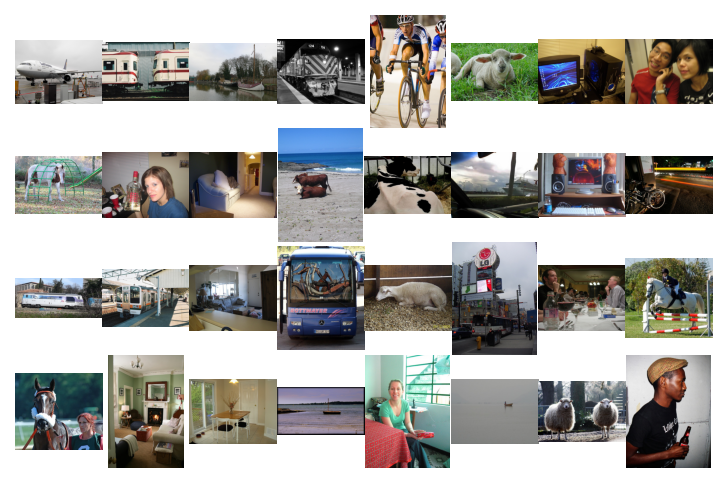

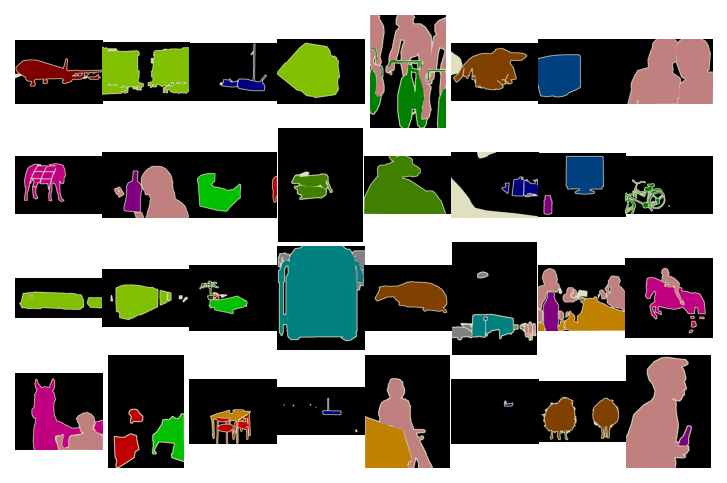

In [5]:
# Some info regarding the dataset
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
# Plot some sample
inputs, ground_truths = map(list, zip(*[val_dataset[i] for i in range(32)]))
_ = plot_images(inputs)
_ = plot_images(ground_truths)

# Data Transformation 

Pytorch provides several function to transform and augment images in the module [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html). Here, we will first resize the images to a fixed size and after that we will apply normalization using some standard values using in semantic segmentation. For label images we also replace the void label (255) with background (0). Finally, we load again the datasets providing the created segmentation for inputs and targets.

In [6]:
image_size = 520 # We will resize to a standard size
image_mean = [0.485, 0.456, 0.406]  # These are some standard for image normalization 
image_std = [0.229, 0.224, 0.225]  # in deep learning
input_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize(image_mean, image_std),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.NEAREST),
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 0)),
    ]
)

# Creating (and downloading) the dataset
train_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2012',
    download=True,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)
val_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2012',
    download=True,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)

Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets/
Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets/


# Let's try some pre-trained models

Pytorch provides several pre-trained models in the module [torchvision.models](https://pytorch.org/vision/stable/models.html). In this notebook, we are interested in semantic segmentation models which can be found at https://pytorch.org/vision/stable/models.html#semantic-segmentation. Let's try the Fully-Convolutional Network model with a ResNet-50 backbone trained on another dataset with the 20 categories of PascalVOC (from the [Fully Convolutional Networks for Semantic Segmentation paper](https://arxiv.org/abs/1411.4038)). We first plot some results compared with the ground truth and then we use some metrics to evaluate the accuracy of the segmentation.

#### Note: the cell below should print cuda:0, otherwise change the runtime on Google Colab

In [12]:
# Set device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)

The current processor is ... cuda:0


In [13]:
# Dataloader are iterative objects than automatically group data samples in batches 
# and return them with the transformation specified in the dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#Exercise: Testing a first pretrained model

Check the model description below and try to understand its components. Focus on the Bottleneck component(s), which of the two residual blocks represented in figure 5 of the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) is implemented?

Note: In PyTorch a convolution with $I$ input channels and $O$ ouput channels is defined as Conv2D($I$, $O$)

# Answer

The bottleneck is implemented (the right figure represented in figure 5 of the provided paper) 

In [10]:
# Load pre-trained weights and create the model
weights = FCN_ResNet50_Weights.DEFAULT
model = torchvision.models.segmentation.fcn_resnet50(weights=weights)
print(model)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Now we try to feed some samples and visualize the resulting segmentation.

Predictions


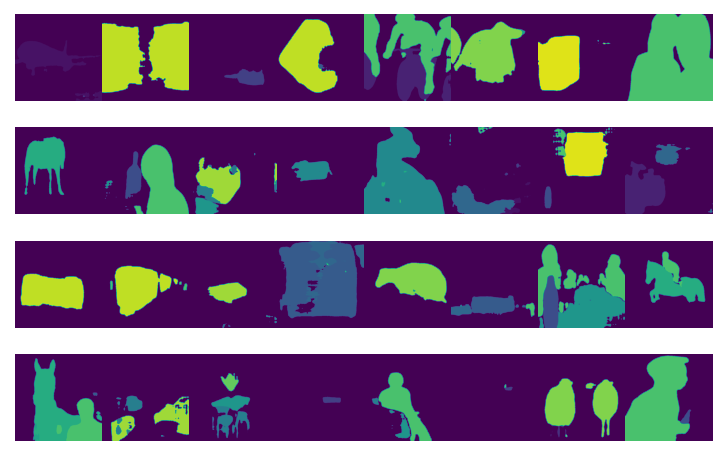

Label


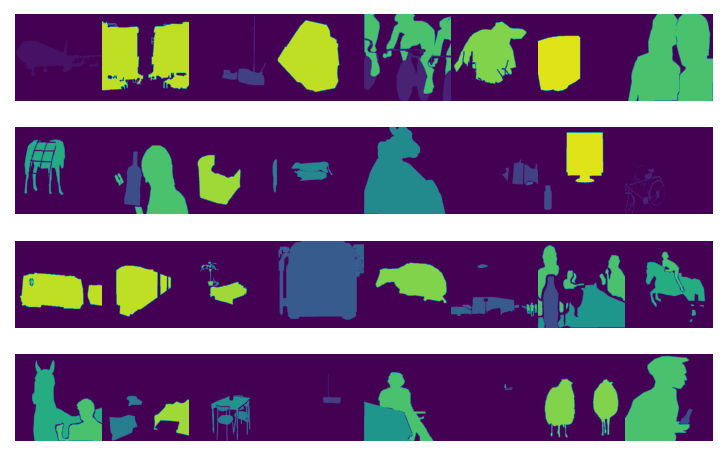

In [11]:
# Move model to device
model.to(device)
model.eval()

# In val, disactivate gradient computation to save memory
with torch.no_grad():
  for batch in valid_loader:
      data, label = batch # data = x, label = y

      # Move data to device
      data, label = data.to(device), label.to(device)
      output = model(data)

      # The second output is known as an auxiliary output and is contained 
      # in the AuxLogits part of the network. We use just the 'out'.
      prediction = output['out'].argmax(dim=1).squeeze()
      print("Predictions")
      _ = plot_images(prediction.cpu(), vmax=21, title='prediction')
      plt.show()
      print("Label")
      _ = plot_images(label.cpu(), vmax=21, title='label')
      plt.show()
      break

# Dice accuracy
Let $T_P$, $F_N$ and $F_P$ be the true positives, false negatives and false positives, we define the Dice accuracy as:

$$ Dice = \frac{2 T_P}{2 T_P + F_N + F_P}$$

We use the multi-class implementation of Dice accuracy provided by the torchmetrics library. Check the documentation here https://torchmetrics.readthedocs.io/en/stable/classification/dice.html.

In [12]:
# Start metric
dice = torchmetrics.Dice().to(device)
model.eval()
with torch.no_grad():
  for idx, batch in enumerate(valid_loader):
      start = time.time()
      data, label = batch
      data, label = data.to(device), label.to(device)
      output = model(data)
      logits = output['out']

      # Add this batch to metric computation
      dice.update(logits, label)
      print(f"Batch {idx} inference in {time.time() - start} seconds")

# Compute the total Dice on the whole validation set
print(f"Average DICE accuracy on validation set: {dice.compute().item()*100} %")

# Important to reset and free memory
dice.reset()

Batch 0 inference in 2.3019461631774902 seconds
Batch 1 inference in 2.3781321048736572 seconds
Batch 2 inference in 2.2882308959960938 seconds
Batch 3 inference in 2.2990152835845947 seconds
Batch 4 inference in 2.297281265258789 seconds
Batch 5 inference in 2.3386151790618896 seconds
Batch 6 inference in 2.3572041988372803 seconds
Batch 7 inference in 2.3080084323883057 seconds
Batch 8 inference in 2.3274424076080322 seconds
Batch 9 inference in 2.319988965988159 seconds
Batch 10 inference in 2.3160200119018555 seconds
Batch 11 inference in 2.3778326511383057 seconds
Batch 12 inference in 2.3752572536468506 seconds
Batch 13 inference in 2.332115888595581 seconds
Batch 14 inference in 2.3507564067840576 seconds
Batch 15 inference in 2.353757619857788 seconds
Batch 16 inference in 2.3603057861328125 seconds
Batch 17 inference in 2.4289164543151855 seconds
Batch 18 inference in 2.3564188480377197 seconds
Batch 19 inference in 2.3743669986724854 seconds
Batch 20 inference in 2.3866748809

# Exercise: a new the pretrained model
##Pretrained model: DeepLabV3_ResNet101

Based on the previous cells try some other pretrained model from the torchvision.models module. Check the available modlues and weights here https://pytorch.org/vision/stable/models.html#semantic-segmentation. Are the model you tried better or worst than the Fully-Convolutional Network model with a ResNet-50 backbone? Do you see any difference in the predictions? Why?

In [ ]:
# TODO: write the code here to test another pre-trained model as previously done
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights
weights = DeepLabV3_ResNet101_Weights.DEFAULT
model1 = torchvision.models.segmentation.deeplabv3_resnet101(weights=weights)
print(model1)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Predictions


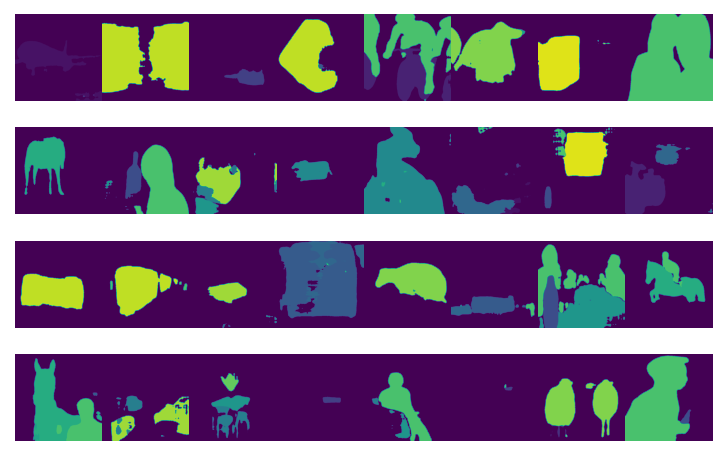

Label


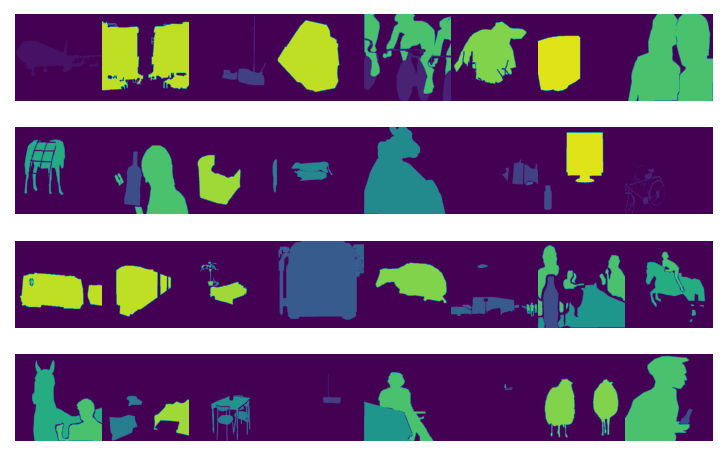

In [ ]:
# Move model to device
model1.to(device)
model1.eval()

# In val, disactivate gradient computation to save memory
with torch.no_grad():
  for batch in valid_loader:
      data, label = batch

      # Move data to device
      data, label = data.to(device), label.to(device)
      output = model(data)
      
      # The second output is known as an auxiliary output and is contained 
      # in the AuxLogits part of the network. We use just the 'out'.
      prediction = output['out'].argmax(dim=1).squeeze()
      print("Predictions")
      _ = plot_images(prediction.cpu(), vmax=21, title='prediction')
      plt.show()
      print("Label")
      _ = plot_images(label.cpu(), vmax=21, title='label')
      plt.show()
      break

In [ ]:
# Start metric
dice = torchmetrics.Dice().to(device)
model1.eval()
with torch.no_grad():
  for idx, batch in enumerate(valid_loader):
      start = time.time()
      data, label = batch
      data, label = data.to(device), label.to(device)
      output = model1(data)
      logits = output['out']
      # Add this batch to metric computation
      dice.update(logits, label)
      print(f"Batch {idx} inference in {time.time() - start} seconds")
# Compute the total Dice on the whole validation set
print(f"Average DICE accuracy on validation set: {dice.compute().item()*100} %")
# Important to reset and free memory
dice.reset()

Batch 0 inference in 5.621896982192993 seconds
Batch 1 inference in 5.904482364654541 seconds
Batch 2 inference in 6.024179697036743 seconds
Batch 3 inference in 6.024341106414795 seconds
Batch 4 inference in 5.866903781890869 seconds
Batch 5 inference in 5.76952862739563 seconds
Batch 6 inference in 5.686087131500244 seconds
Batch 7 inference in 5.604154586791992 seconds
Batch 8 inference in 5.571493864059448 seconds
Batch 9 inference in 5.542464256286621 seconds
Batch 10 inference in 5.540849208831787 seconds
Batch 11 inference in 5.548676252365112 seconds
Batch 12 inference in 5.549408197402954 seconds
Batch 13 inference in 5.664070129394531 seconds
Batch 14 inference in 5.659951210021973 seconds
Batch 15 inference in 5.630302906036377 seconds
Batch 16 inference in 5.662578582763672 seconds
Batch 17 inference in 5.736663341522217 seconds
Batch 18 inference in 5.723703622817993 seconds
Batch 19 inference in 5.736198902130127 seconds
Batch 20 inference in 5.697744846343994 seconds
Bat

Conclusion: I use the DeepLabV3_ResNet101 pretrained weight hich had a better accuracy (92,3%) than Fully-Convolutional Network model with a ResNet-50 backbone (90,9%). This raise in accuracy is probably due to the fact that the DeepLabV3_ResNet101 has more trained parameters than ResNet-50 thereby allowing it to generalize better. 

# Let's train a custom module (UNet)

In the following we manually implement the UNet model for image segmentation and we train it from scratch using the standard PyTorch pipeline.

First we define the modules for each part of the UNet and after we define the complete model from https://github.com/milesial/Pytorch-UNet.

In [7]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, channel_in, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.channel_in = channel_in
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(channel_in, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Now we create and print our UNet model, the inputs channels are 3 (RGB) and the output calsses are 21 (20 objects + background)

In [9]:
# Create the model and print it
model = UNet(channel_in=3, n_classes=21, bilinear=True)
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

We also load again the data with different resizing and batch size to don't fill the GPUs memory and have a 'CUDA out of memory' error.

In [10]:
image_size = 224 # We will resize to a standard size
image_mean = [0.485, 0.456, 0.406]  # These are some standard for image noramization 
image_std = [0.229, 0.224, 0.225]  # in deep learning
input_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize(image_mean, image_std),
    ]
)
target_transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.NEAREST),
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: replace_tensor_value_(x.squeeze(0).long(), 255, 0)),
    ]
)
# Creating (and downloading) the dataset
train_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2012',
    download=True,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)
val_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2012',
    download=True,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets/
Using downloaded and verified file: ./datasets/VOCtrainval_11-May-2012.tar
Extracting ./datasets/VOCtrainval_11-May-2012.tar to ./datasets/


We define in the following all the parameters that will be used in the training. Namely:

<ul>
  <li> Learning rate </li>
  <li> Number of epochs </li>
  <li> Optimizer: Adam </li>
  <li> Loss function:  Cross Entropy (CE) loss.</li>
  <li> Function to compute the validation accuracy (DICE as before)</li>
</ul>


In [24]:
learning_rate = 0.001 #changed from 1e-5 to 0.001 then to 0.0005
epochs = 30 #changed from 20 62% to 60 77% to 30 76.3% to 40
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
dice = torchmetrics.Dice().to(device)


#Exercise: Training of the Unet for the segmentation task

We implement in the next cell, the classic PyTorch pipeline, structure as follow to perform the training of the UNet. Fill the missing code blocks (TODO). After that try to change the learning rate and the number of epochs, what is the impact on the final result ? If you want apply also other changes in the model or loss function to try to improve the results. It is not easy to find the good combination of parameters giving good results, but you will see the loss decreasing during training and the accuracy increasing anyway

In [22]:
#Learning rate = 0.001 and 60 Epochs

model = model.to(device)
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):  # loop over the dataset multiple times

    # One train set iteration
    running_loss = 0.0
    last_train_loss = 0.0
    model.train()

    for idx, batch in enumerate(train_loader):

      # TODO: Fetch batch data as in the previous validation loops
      start = time.time()
      data, label = batch
      data, label = data.to(device), label.to(device)


      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      # TODO: Feed data into the network and store the ouput
      output_train = model(data) 
      # TODO: Compute loss using the criterion previously defined
      loss = criterion(output_train,label)

      # backward + optimize
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if idx % 10 == 9:    # print every 10 mini-batches
          print(f'[{epoch + 1}, {idx + 1:5d}] loss: {running_loss / 10:.3f}')
          last_train_loss = running_loss / 10
          running_loss = 0.0

    train_losses.append(last_train_loss)
    print(f"Final test set loss for epoch {epoch + 1}: {last_train_loss:.3f}")

    # Validation loop
    model.eval()
    val_loss = 0.0

    # TODO: Validation loop (see previous cells), accumulate the loss and the accuracy over the entire validation loader
    with torch.no_grad():
      for idx, batch in enumerate(valid_loader):
        start = time.time()
        data, label = batch
        data, label = data.to(device), label.to(device)
        output_valid = model(data) 
        loss = criterion(output_valid,label)
        val_loss += loss.item()
        
        dice.update(output_valid,label)

    # AFter the validation iteration ends compute the total Dice on the whole validation set
    val_loss = val_loss / len(valid_loader)
    val_acc = dice.compute().item()*100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Loss on validation set for epoch {epoch + 1}: {val_loss:.3f}")
    print(f"Average DICE accuracy on validation set for epoch {epoch + 1}: {val_acc} %")
    dice.reset()

print('Finished Training')

# Save model
#torch.save(model.state_dict(), 'models/unet_v0.pt')



# If you want load the trained model see https://pytorch.org/tutorials/beginner/saving_loading_models.html

[1,    10] loss: 0.951
[1,    20] loss: 0.934
[1,    30] loss: 0.921
[1,    40] loss: 0.966
[1,    50] loss: 0.896
[1,    60] loss: 0.952
[1,    70] loss: 0.918
[1,    80] loss: 0.922
[1,    90] loss: 0.892
Final test set loss for epoch 1: 0.892
Loss on validation set for epoch 1: 0.970
Average DICE accuracy on validation set for epoch 1: 75.05844831466675 %
[2,    10] loss: 0.888
[2,    20] loss: 0.906
[2,    30] loss: 0.926
[2,    40] loss: 0.974
[2,    50] loss: 0.831
[2,    60] loss: 0.911
[2,    70] loss: 0.917
[2,    80] loss: 0.914
[2,    90] loss: 0.912
Final test set loss for epoch 2: 0.912
Loss on validation set for epoch 2: 0.938
Average DICE accuracy on validation set for epoch 2: 75.11764764785767 %
[3,    10] loss: 0.838
[3,    20] loss: 0.864
[3,    30] loss: 0.902
[3,    40] loss: 0.884
[3,    50] loss: 0.920
[3,    60] loss: 0.777
[3,    70] loss: 0.920
[3,    80] loss: 0.962
[3,    90] loss: 0.924
Final test set loss for epoch 3: 0.924
Loss on validation set for epoch

In [25]:
#Learning rate = 0.001 and 30 epochs

model = model.to(device)
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):  # loop over the dataset multiple times

    # One train set iteration
    running_loss = 0.0
    last_train_loss = 0.0
    model.train()

    for idx, batch in enumerate(train_loader):

      # TODO: Fetch batch data as in the previous validation loops
      start = time.time()
      data, label = batch
      data, label = data.to(device), label.to(device)


      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      # TODO: Feed data into the network and store the ouput
      output_train = model(data) 
      # TODO: Compute loss using the criterion previously defined
      loss = criterion(output_train,label)

      # backward + optimize
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if idx % 10 == 9:    # print every 10 mini-batches
          print(f'[{epoch + 1}, {idx + 1:5d}] loss: {running_loss / 10:.3f}')
          last_train_loss = running_loss / 10
          running_loss = 0.0

    train_losses.append(last_train_loss)
    print(f"Final test set loss for epoch {epoch + 1}: {last_train_loss:.3f}")

    # Validation loop
    model.eval()
    val_loss = 0.0

    # TODO: Validation loop (see previous cells), accumulate the loss and the accuracy over the entire validation loader
    with torch.no_grad():
      for idx, batch in enumerate(valid_loader):
        start = time.time()
        data, label = batch
        data, label = data.to(device), label.to(device)
        output_valid = model(data) 
        loss = criterion(output_valid,label)
        val_loss += loss.item()
        
        dice.update(output_valid,label)

    # AFter the validation iteration ends compute the total Dice on the whole validation set
    val_loss = val_loss / len(valid_loader)
    val_acc = dice.compute().item()*100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Loss on validation set for epoch {epoch + 1}: {val_loss:.3f}")
    print(f"Average DICE accuracy on validation set for epoch {epoch + 1}: {val_acc} %")
    dice.reset()

print('Finished Training')

# Save model
#torch.save(model.state_dict(), 'models/unet_v0.pt')



# If you want load the trained model see https://pytorch.org/tutorials/beginner/saving_loading_models.html

[1,    10] loss: 1.017
[1,    20] loss: 0.965
[1,    30] loss: 0.985
[1,    40] loss: 0.974
Final test set loss for epoch 1: 0.974
Loss on validation set for epoch 1: 1.042
Average DICE accuracy on validation set for epoch 1: 75.36665797233582 %
[2,    10] loss: 1.031
[2,    20] loss: 0.954
[2,    30] loss: 0.963
[2,    40] loss: 0.958
Final test set loss for epoch 2: 0.958
Loss on validation set for epoch 2: 1.048
Average DICE accuracy on validation set for epoch 2: 75.3207266330719 %
[3,    10] loss: 0.986
[3,    20] loss: 0.997
[3,    30] loss: 0.949
[3,    40] loss: 0.945
Final test set loss for epoch 3: 0.945
Loss on validation set for epoch 3: 1.037
Average DICE accuracy on validation set for epoch 3: 75.3593385219574 %
[4,    10] loss: 0.997
[4,    20] loss: 0.892
[4,    30] loss: 0.935
[4,    40] loss: 1.019
Final test set loss for epoch 4: 1.019
Loss on validation set for epoch 4: 1.030
Average DICE accuracy on validation set for epoch 4: 75.35099983215332 %
[5,    10] loss: 0

In [19]:
#Learning rate = 0.0005 and 40 epochs

model = model.to(device)
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):  # loop over the dataset multiple times

    # One train set iteration
    running_loss = 0.0
    last_train_loss = 0.0
    model.train()

    for idx, batch in enumerate(train_loader):

      # TODO: Fetch batch data as in the previous validation loops
      start = time.time()
      data, label = batch
      data, label = data.to(device), label.to(device)


      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      # TODO: Feed data into the network and store the ouput
      output_train = model(data) 
      # TODO: Compute loss using the criterion previously defined
      loss = criterion(output_train,label)

      # backward + optimize
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if idx % 10 == 9:    # print every 10 mini-batches
          print(f'[{epoch + 1}, {idx + 1:5d}] loss: {running_loss / 10:.3f}')
          last_train_loss = running_loss / 10
          running_loss = 0.0

    train_losses.append(last_train_loss)
    print(f"Final test set loss for epoch {epoch + 1}: {last_train_loss:.3f}")

    # Validation loop
    model.eval()
    val_loss = 0.0

    # TODO: Validation loop (see previous cells), accumulate the loss and the accuracy over the entire validation loader
    with torch.no_grad():
      for idx, batch in enumerate(valid_loader):
        start = time.time()
        data, label = batch
        data, label = data.to(device), label.to(device)
        output_valid = model(data) 
        loss = criterion(output_valid,label)
        val_loss += loss.item()
        
        dice.update(output_valid,label)

    # AFter the validation iteration ends compute the total Dice on the whole validation set
    val_loss = val_loss / len(valid_loader)
    val_acc = dice.compute().item()*100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Loss on validation set for epoch {epoch + 1}: {val_loss:.3f}")
    print(f"Average DICE accuracy on validation set for epoch {epoch + 1}: {val_acc} %")
    dice.reset()

print('Finished Training')

# Save model
#torch.save(model.state_dict(), 'models/unet_v0.pt')



# If you want load the trained model see https://pytorch.org/tutorials/beginner/saving_loading_models.html

[1,    10] loss: 0.715
[1,    20] loss: 0.781
[1,    30] loss: 0.827
[1,    40] loss: 0.731
Final test set loss for epoch 1: 0.731
Loss on validation set for epoch 1: 0.933
Average DICE accuracy on validation set for epoch 1: 76.26355290412903 %
[2,    10] loss: 0.716
[2,    20] loss: 0.685
[2,    30] loss: 0.731
[2,    40] loss: 0.736
Final test set loss for epoch 2: 0.736
Loss on validation set for epoch 2: 0.886
Average DICE accuracy on validation set for epoch 2: 77.14053392410278 %
[3,    10] loss: 0.674
[3,    20] loss: 0.714
[3,    30] loss: 0.722
[3,    40] loss: 0.705
Final test set loss for epoch 3: 0.705
Loss on validation set for epoch 3: 0.884
Average DICE accuracy on validation set for epoch 3: 77.20810174942017 %
[4,    10] loss: 0.670
[4,    20] loss: 0.668
[4,    30] loss: 0.716
[4,    40] loss: 0.710
Final test set loss for epoch 4: 0.710
Loss on validation set for epoch 4: 0.911
Average DICE accuracy on validation set for epoch 4: 76.98728442192078 %
[5,    10] loss:

In [22]:
#Learning rate = 0.01 and 20 Epochs

model = model.to(device)
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):  # loop over the dataset multiple times

    # One train set iteration
    running_loss = 0.0
    last_train_loss = 0.0
    model.train()

    for idx, batch in enumerate(train_loader):

      # TODO: Fetch batch data as in the previous validation loops
      start = time.time()
      data, label = batch
      data, label = data.to(device), label.to(device)


      # zero the parameter gradients
      optimizer.zero_grad()

      # forward
      # TODO: Feed data into the network and store the ouput
      output_train = model(data) 
      # TODO: Compute loss using the criterion previously defined
      loss = criterion(output_train,label)

      # backward + optimize
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if idx % 10 == 9:    # print every 10 mini-batches
          print(f'[{epoch + 1}, {idx + 1:5d}] loss: {running_loss / 10:.3f}')
          last_train_loss = running_loss / 10
          running_loss = 0.0

    train_losses.append(last_train_loss)
    print(f"Final test set loss for epoch {epoch + 1}: {last_train_loss:.3f}")

    # Validation loop
    model.eval()
    val_loss = 0.0

    # TODO: Validation loop (see previous cells), accumulate the loss and the accuracy over the entire validation loader
    with torch.no_grad():
      for idx, batch in enumerate(valid_loader):
        start = time.time()
        data, label = batch
        data, label = data.to(device), label.to(device)
        output_valid = model(data) 
        loss = criterion(output_valid,label)
        val_loss += loss.item()
        
        dice.update(output_valid,label)

    # AFter the validation iteration ends compute the total Dice on the whole validation set
    val_loss = val_loss / len(valid_loader)
    val_acc = dice.compute().item()*100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Loss on validation set for epoch {epoch + 1}: {val_loss:.3f}")
    print(f"Average DICE accuracy on validation set for epoch {epoch + 1}: {val_acc} %")
    dice.reset()

print('Finished Training')

# Save model
#torch.save(model.state_dict(), 'models/unet_v0.pt')



# If you want load the trained model see https://pytorch.org/tutorials/beginner/saving_loading_models.html

[1,    10] loss: 1.422
[1,    20] loss: 1.325
[1,    30] loss: 1.230
[1,    40] loss: 1.257
Final test set loss for epoch 1: 1.257
Loss on validation set for epoch 1: 1.239
Average DICE accuracy on validation set for epoch 1: 74.73347187042236 %
[2,    10] loss: 1.245
[2,    20] loss: 1.238
[2,    30] loss: 1.235
[2,    40] loss: 1.197
Final test set loss for epoch 2: 1.197
Loss on validation set for epoch 2: 1.298
Average DICE accuracy on validation set for epoch 2: 74.23153519630432 %
[3,    10] loss: 1.122
[3,    20] loss: 1.192
[3,    30] loss: 1.205
[3,    40] loss: 1.175
Final test set loss for epoch 3: 1.175
Loss on validation set for epoch 3: 1.194
Average DICE accuracy on validation set for epoch 3: 74.6075689792633 %
[4,    10] loss: 1.170
[4,    20] loss: 1.150
[4,    30] loss: 1.122
[4,    40] loss: 1.123
Final test set loss for epoch 4: 1.123
Loss on validation set for epoch 4: 1.199
Average DICE accuracy on validation set for epoch 4: 74.69014525413513 %
[5,    10] loss: 

# Plot the loss and accuracy graphs of the training

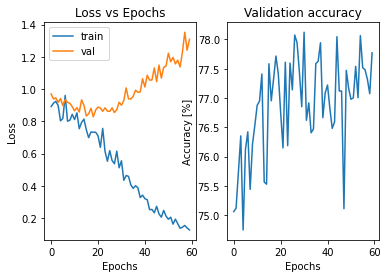

In [23]:
# Plot Train vs Val loss over epochs: lr = 0.001 and 60 epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.ylabel("Accuracy [%]")
plt.xlabel("Epochs")
plt.title("Validation accuracy")
plt.show()

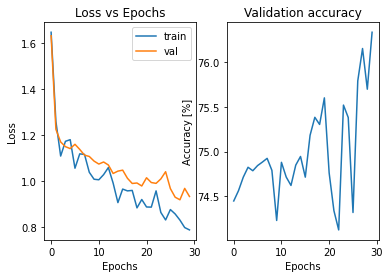

In [16]:
# Plot Train vs Val loss over epochs: lr = 0.001 and 30 epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.ylabel("Accuracy [%]")
plt.xlabel("Epochs")
plt.title("Validation accuracy")
plt.show()

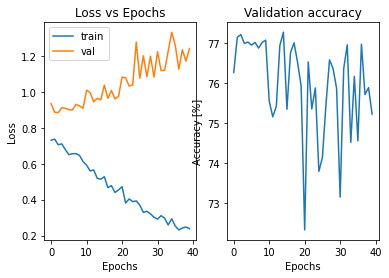

In [20]:
# Plot Train vs Val loss over epochs: lr = 0.0005 and 40 epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.ylabel("Accuracy [%]")
plt.xlabel("Epochs")
plt.title("Validation accuracy")
plt.show()

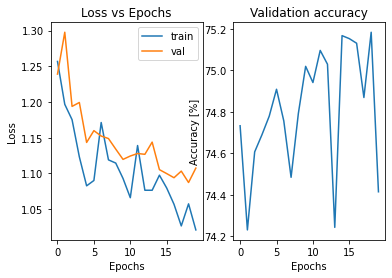

In [23]:
# Plot Train vs Val loss over epochs: lr = 0.0005 and 40 epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("Loss vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.ylabel("Accuracy [%]")
plt.xlabel("Epochs")
plt.title("Validation accuracy")
plt.show()

CONCLUSION:

I implemented the training for the a unet model on a segmentation task.
I tried to fine tune the model by changing the learning rate and the number of epochs. 
I achieved the best result by using a learning rate of 0.001 with 30 epochs. 
with a learning rate of 0.001 (60 epochs) and 0.0005 (40 epochs) the validation loss started diverging form the training loss showing that the model was overfitting. 
I reduced the overfitting problem by reducing the training time to 30 epochs. I could also change the model directly to solve this overfitting problem by adding dropout in the layers or some gaussian noise at th input of the model but I did not have enought tie to explore these possibilities. 

# Show segmentation of one validation batch

Predictions


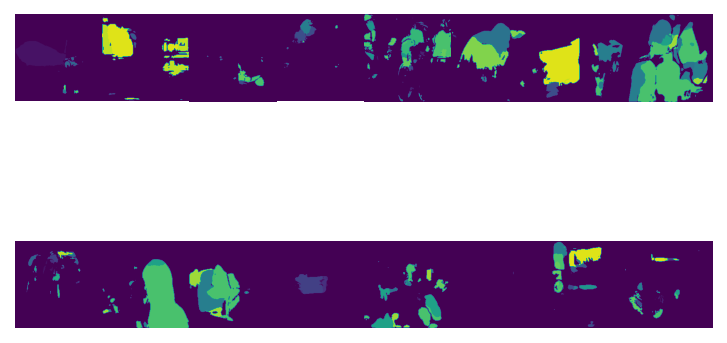

Label


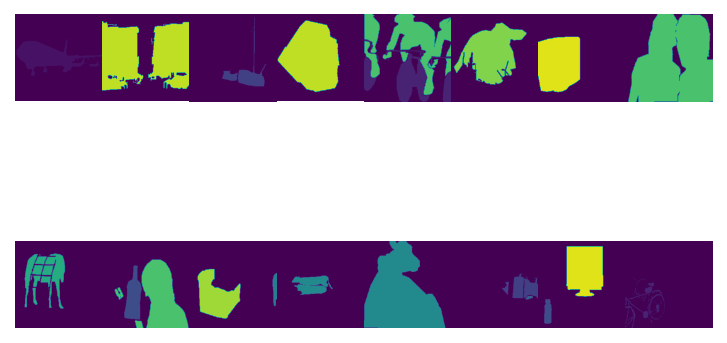

In [24]:
model.eval()
# In val, disactivate gradient computation to save memory
with torch.no_grad():
  for batch in valid_loader:
      data, labels = batch
      # Move data to device
      data, labels = data.to(device), labels.to(device)
      output = model(data)
      # The second output is known as an auxiliary output and is contained 
      # in the AuxLogits part of the network. We use just the 'out'.
      prediction = output.argmax(dim=1).squeeze()
      print("Predictions")
      _ = plot_images(prediction.cpu(), vmax=21, title='prediction')
      plt.show()
      print("Label")
      _ = plot_images(labels.cpu(), vmax=21, title='label')
      plt.show()
      break

#Additional Exercise:

Add the parameter n_channels to the UNet initialization and define the convolutions input and output sizes proportional to this paramtetr. 

```
class UNet(nn.Module):
    def __init__(self, channel_in, n_classes, n_channels, bilinear=False):
        super(UNet, self).__init__()
        ...
```

####Note: at each layer of UNet the features size, i.e. output channels, is doubled. Try to use the parameter n_channels as ouptput size of the first convolutions and make the followings proportional.

In [ ]:
# TODO: write the new model class here